# Encoding the Audio

In [2]:
import sys 
import os 
import pickle 
import numpy as np
import spacy
import seaborn as sns
import matplotlib as plt 
import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath("../lingpred_new/"))
from plotting import colours
from encoding_analysis import regress_out_one, make_arbitrary_static_vectors, brainscore_no_coef
from utils import get_words_onsets_offsets, get_indices_per_task, make_y_matrix_per_run


In [3]:
dataset  = 'Goldstein'

# Let's get X matrices for arbitrary vectors:
words_df = get_words_onsets_offsets(dataset)
X        = make_arbitrary_static_vectors(words_df, dim=300)

X_residualised = regress_out_one(X)
X.shape, X_residualised.shape


((5136, 300), (5135, 300))

In [4]:

with open('/Users/ines/research/Lingpred/audio/Goldstein/acoustic_model_8_mels_averaged_per_word.pkl', 'rb') as f:
    acoustics = pickle.load(f)

acoustics.shape

(5136, 9)

In [5]:
'''
Compute the indices for making the y matrix
-------------------------------------------
This is already saved under audio/Goldstein/indices_all_tasks.pkl
No need to run this again, this will take 10 min

#indices = get_indices_per_task(dataset)
#indices.shape

dir_path = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'indices_all_tasks.pkl'
path      = dir_path + file_name

print(path)
f = open(path,"wb")
pickle.dump(indices, f)
f.close()
'''


# load the indices:
with open('/Users/ines/research/Lingpred/audio/Goldstein/indices_all_tasks.pkl', 'rb') as f:
    indices = pickle.load(f)

indices.shape

(5136, 157)

In [6]:
# check that they look alright:
indices[:1], indices[-1:]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5]]),
 array([[5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5130, 5130,
         5130, 5130, 5130, 5131, 5131, 5131, 5131, 5131, 5132, 5132, 5132,
         5132, 5132, 5133, 5133, 5133, 5133, 5133, 5133, 5133, 5133, 5133,
    

In [7]:
# use indices to make an acoustic y matrix of shape (length, 157, dim)
y_acoustics = make_y_matrix_per_run(acoustics, indices)
y_acoustics.shape

(5136, 157, 9)

In [8]:
y_acoustics[1, 0:10, 0] # check the first 9 values for the first timepoint/word

array([8.04137516, 8.04137516, 8.04137516, 8.04137516, 8.04137516,
       8.04137516, 8.04137516, 8.04137516, 8.04137516, 8.04137516])

In [9]:
annotations_df = get_words_onsets_offsets(dataset)
annotations_df.head()

,word,onset,offset
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


In [10]:
nlp     = spacy.load('en_core_web_lg')
X_Glove = np.vstack([nlp(word).vector for word in annotations_df.word]) # np array of shape (nr_words, 300)
#X_Glove = np.array(X_Glove.get()) # transform from cupy to numpy array for stacking later on 
X_Glove_residualised = regress_out_one(X_Glove)
X_Glove.shape, X_Glove_residualised.shape
    

((5136, 300), (5135, 300))

In [29]:
y = y_acoustics[1:]
y = np.swapaxes(y, 0, 1)
print('y has shape ', y.shape)

encoding_arbitrary_residualised = brainscore_no_coef(X_residualised, y)
encoding_Glove_residualised     = brainscore_no_coef(X_Glove_residualised, y)

y has shape  (157, 5135, 9)
We are now in the brainscore_no_coef method, and y has shape:
(157, 5135, 9)
We are now in the brainscore_no_coef method, and y has shape:
(157, 5135, 9)


In [23]:
directory = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_Glove', 'corr_arbitrary']
values  = [encoding_Glove_residualised, encoding_arbitrary_residualised]
results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(results, f)
f.close()


/Users/ines/research/Lingpred/audio/Goldstein/regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl


In [12]:
y = y_acoustics
y = np.swapaxes(y, 0, 1)
print('y has shape ', y.shape)

encoding_arbitrary = brainscore_no_coef(X, y)
encoding_Glove     = brainscore_no_coef(X_Glove, y)

y has shape  (157, 5136, 9)
We are now in the brainscore_no_coef method, and y has shape:
(157, 5136, 9)
We are now in the brainscore_no_coef method, and y has shape:
(157, 5136, 9)


In [13]:
directory = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_Glove', 'corr_arbitrary']
values  = [encoding_Glove, encoding_arbitrary]
results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(results, f)
f.close()

/Users/ines/research/Lingpred/audio/Goldstein/vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl


In [14]:
from plotting import times_100, lowerCI, upperCI, reshape

In [27]:
encoding_Glove_residualised.shape

(157, 10, 9)

In [23]:
encoding_Glove.reshape(-1, encoding_Glove.shape[0]).shape

(90, 157)

In [24]:
def reshape_x(x):
    return x.reshape(-1, x.shape[0])

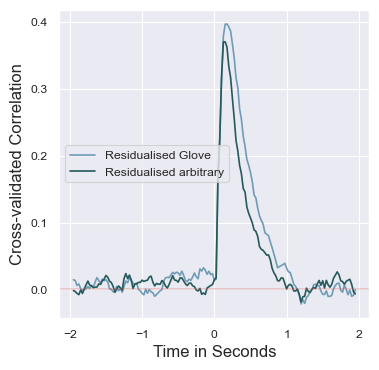

In [30]:
# get model names
models = [k.split(sep='_')[1] for k in results.keys()]
labels = ['Residualised '+m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(results.keys()):
    ax1.plot(times_100, results[key].mean(axis=1).mean(axis=1), c=colours[models[i]], label=labels[i])   
    #ax1.fill_between(times_100[:78], lowerCI(reshape_x(results[key][:, :, :78])), 
    #                            upperCI(reshape_x(results[key][:, :, :78])), color=colours[models[i]], alpha=0.3)

ax1.legend()
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+':' + vectors)

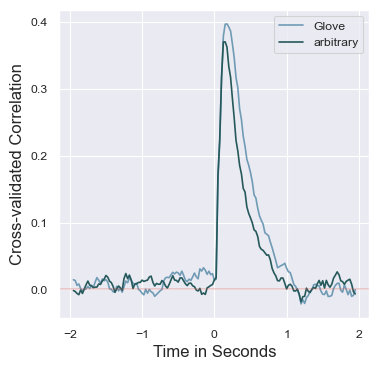

In [28]:
# get model names
models = [k.split(sep='_')[1] for k in results.keys()]
labels = [m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(results.keys()):
    ax1.plot(times_100, results[key].mean(axis=1).mean(axis=1), c=colours[models[i]], label=labels[i])   
    #ax1.fill_between(times_100[:78], lowerCI(reshape_x(results[key][:78,:, :])), 
    #                            upperCI(reshape_x(results[key][:78,:, :])), color=colours[models[i]], alpha=0.3)

ax1.legend()
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+':' + vectors)